# Install Libraries

In [1]:
!pip3 install parsivar
!pip install nltk==3.2.2
!pip install clean_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.2.2-py3-none-any.whl size=1353248 sha256=83b3621ab78fc204d58d605b82fe6a051a20a1a3259f9dcbcc12f8a623cb0d09
  Stored in directory: /root/.cache/pip/wheels/ba/64/d0/28a3b1b1914873a93b118ee166980a98823eadf0616070700a
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
parsivar 0.2.3.1 requires nltk>=3.6.6, but you have nltk 3.2.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ..

In [2]:
from parsivar import Tokenizer , Normalizer
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
from cleantext import clean
from torch import cuda
from parsivar import Tokenizer
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import DistilBertTokenizer, DistilBertModel, BertConfig, BertTokenizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import warnings
import logging

# PreProcessing

In [3]:
# Initialize the Parsivar Normalizer
normalizer = Normalizer(statistical_space_correction=True)
tokenizer = Tokenizer()

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>') # regular expression for finding tags
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def cleaning(text):
    text = text.strip() # first and last white spaces will be removed.

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )
    # cleaning htmls
    text = cleanhtml(text)

    text = normalizer.normalize(text)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    text = wierd_pattern.sub(r'', text)
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text) # covert multiple white spaces to single one
    return text

In [5]:
# train data
df = pd.read_csv('/content/train.tsv',sep='\t' , names=['text', 'labels'])
df.head()

,text,labels
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,OTHER
4,اين وضع ب طرز خنده داري گريه داره ...,SAD


In [6]:
df['text'] = df['text'].apply(cleaning)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,labels
0,آخه‌مادرجنده‌چاقال تو جای یه چک نداری واسه دخت...,ANGRY
1,انقدر صحنه‌خفنی بود خودم از خنده مرده بودم :))...,HAPPY
2,""" من از این شماره استفاده کردم ولی سرخابی نیس...",OTHER
3,یه گوسفنده قرص‌اکس‌میخوره‌میره لب جاده‌میگه : ...,OTHER
4,یعنی باشوگرمامی یا ددی ازدواج میکنن ؟ ‌مگه فقط...,SURPRISE


In [7]:
# test data
df_test = pd.read_csv('/content/test.tsv',sep='\t' , names=['text', 'labels'])
df_test.head()

,text,labels
0,اين شايد اولين عزاى عمومى واقعى است كه ياد دار...,SAD
1,دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...,HAPPY
2,کدوم شعبه پول نداده، بگو الان برات آمار دقیق ...,OTHER
3,امروز وسط یه بحث با بابا مامانم گفتم آدم باید ...,HAPPY
4,امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...,SAD


In [8]:
df_test['text'] = df_test['text'].apply(cleaning)
df_test = df.sample(frac=1).reset_index(drop=True)
df_test.head()

,text,labels
0,اوج‌ناحرفه‌ای گری یک رسانه‌مسئولان‌قطری شایعه ...,SAD
1,حالا شما جدی نگیرید ولی نصف مسیر موفقیت به واس...,OTHER
2,من فهمیدم 206 خودش یه کرمی داره که هرکی‌پشتش‌م...,OTHER
3,وای من همیشه فوبیاشو دارم,FEAR
4,میگم یه وقت زشت نباشه من کلا‌نمیدونم‌فیو‌و کوت...,SAD


# Label One-Hot Encoding

In [9]:
def one_hot_encoder(df):
  for index, row in df.iterrows():
    if row["labels"] =="ANGRY":
        row["labels"]=[0, 0, 0, 0, 0, 0, 1]
    elif row["labels"] =="FEAR":
        row["labels"]=[0, 0, 0, 0, 0, 1, 0]
    elif row["labels"] =="HAPPY":
        row["labels"]=[0, 0, 0, 0, 1, 0, 0]
    elif row["labels"] =="HATE":
        row["labels"]=[0, 0, 0, 1, 0, 0, 0]
    elif row["labels"] =="SAD":
        row["labels"]=[0, 0, 1, 0, 0, 0, 0]
    elif row["labels"] =="SURPRISE":
        row["labels"]=[0, 1, 0, 0, 0, 0, 0]
    elif row["labels"] =="OTHER":
        row["labels"]=[1, 0, 0, 0, 0, 0, 0]

In [10]:
categories = ["ANGRY", "FEAR", "HAPPY", "HATE", "SAD", "SURPRISE","OTHER"]

# Convert emotion labels to numerical format (one-hot encoding)
one_hot_encoder(df) # train
one_hot_encoder(df_test) # test

In [11]:
df.head()

,text,labels
0,آخه‌مادرجنده‌چاقال تو جای یه چک نداری واسه دخت...,"[0, 0, 0, 0, 0, 0, 1]"
1,انقدر صحنه‌خفنی بود خودم از خنده مرده بودم :))...,"[0, 0, 0, 0, 1, 0, 0]"
2,""" من از این شماره استفاده کردم ولی سرخابی نیس...","[1, 0, 0, 0, 0, 0, 0]"
3,یه گوسفنده قرص‌اکس‌میخوره‌میره لب جاده‌میگه : ...,"[1, 0, 0, 0, 0, 0, 0]"
4,یعنی باشوگرمامی یا ددی ازدواج میکنن ؟ ‌مگه فقط...,"[0, 1, 0, 0, 0, 0, 0]"


In [12]:
df_test.head()

,text,labels
0,اوج‌ناحرفه‌ای گری یک رسانه‌مسئولان‌قطری شایعه ...,"[0, 0, 1, 0, 0, 0, 0]"
1,حالا شما جدی نگیرید ولی نصف مسیر موفقیت به واس...,"[1, 0, 0, 0, 0, 0, 0]"
2,من فهمیدم 206 خودش یه کرمی داره که هرکی‌پشتش‌م...,"[1, 0, 0, 0, 0, 0, 0]"
3,وای من همیشه فوبیاشو دارم,"[0, 0, 0, 0, 0, 1, 0]"
4,میگم یه وقت زشت نباشه من کلا‌نمیدونم‌فیو‌و کوت...,"[0, 0, 1, 0, 0, 0, 0]"


# Initialization

In [13]:
device = 'cuda' if cuda.is_available() else 'cpu' # gpu for parallel computation
print(f"Device is {device}")

Device is cuda


In [14]:
MAX_LEN=256
BATCH_SIZE = 8
EPOCHS = 8
LEARNING_RATE = 2e-05
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/SA/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [15]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

# Data

In [16]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split()) # only one space between words

        inputs = self.tokenizer.encode_plus( # converting the text into numerical tokens
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids'] # Each word or subword in the text is mapped to a unique integer ID
        mask = inputs['attention_mask'] # recognizing which token should be and should not be attended
        token_type_ids = inputs["token_type_ids"] # unique id for each sentence


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long), # in BERT, this mask is crucial for handling variable-length sequences
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }


In [17]:
print("TRAIN Dataset: {}".format(df.shape))
print("TEST Dataset: {}".format(df_test.shape))

training_set = MultiLabelDataset(df, tokenizer, MAX_LEN)
test_set = MultiLabelDataset(df_test, tokenizer, MAX_LEN)

TRAIN Dataset: (6125, 2)
TEST Dataset: (6125, 2)


In [18]:
train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0 # done in the main process(because of small dataset)
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0 # done in the main process
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(test_set, **test_params)

# Model

In [19]:
# DistilBertModel: https://huggingface.co/docs/transformers/en/model_doc/distilbert
from transformers import BertModel

class ParsBertModel(torch.nn.Module):
    def __init__(self):
        super(ParsBertModel, self).__init__()
        self.l1 = DistilBertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0] # extract hidden states of the output of pre-trained model
        pooler = hidden_state[:, 0] # selecting the hidden states corresponding to the first token in each sequence
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = ParsBertModel()
model.to(device)

You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of DistilBertModel were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['transformer.layer.10.attention.out_lin.bias', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.8.ffn.lin2.weight', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.3.attention.v_lin.weight', 'transformer.layer.10.attention.v_lin.bias', 'transformer.layer.4.attention.v_lin.bias', 'transformer.layer.7.output_layer_norm.bias', 'transformer.layer.10.attention.k_lin.weight', 'transformer.layer.8.attention.q_lin.weight', 'transformer.layer.7.output_layer_norm.weight', 'transformer.layer.9.attention.out_lin.weight', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.2.output_layer_norm.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.4.ffn.lin1.bias', 'transformer.layer.2.ffn.lin2.bias', 'transformer.layer.10.attention.q_lin.bias', 'transformer.layer.3.attention.v_lin.bias', 'transformer.l

ParsBertModel(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-11): 12 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [21]:
def loss_fn(outputs, targets): # binary class entropy and sigmoid
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [22]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

# Train

In [23]:
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        last_loss = loss.item()

        loss.backward()
        optimizer.step() # update model parameters
    print(f'Epoch: {epoch}, Loss:  {last_loss}')

In [24]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
766it [04:45,  2.68it/s]


Epoch: 0, Loss:  1.6169182062149048


766it [04:49,  2.65it/s]


Epoch: 1, Loss:  1.0946969985961914


766it [04:49,  2.65it/s]


Epoch: 2, Loss:  0.9386296272277832


766it [04:48,  2.66it/s]


Epoch: 3, Loss:  0.28252485394477844


766it [04:48,  2.66it/s]


Epoch: 4, Loss:  0.09358184784650803


766it [04:47,  2.66it/s]


Epoch: 5, Loss:  0.11665191501379013


766it [04:47,  2.66it/s]


Epoch: 6, Loss:  0.04648585617542267


766it [04:47,  2.66it/s]

Epoch: 7, Loss:  0.4770215153694153


In [25]:
def predict(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist()) # detach:to prevent gradients from being calculated with respect to the targets
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist()) # appending the model predictions (after sigmoid activation)
    return fin_outputs, fin_targets

In [26]:
outputs, targets = predict(testing_loader)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
766it [01:40,  7.63it/s]


In [27]:
def class_finder(outputs):
  final_outputs= np.zeros_like(outputs)
  for i in range(len(outputs)):
    index=np.argmax(outputs[i])
    final_outputs[i][index]=1
  return final_outputs

In [28]:
final_outputs = class_finder(outputs)

In [29]:
other_final_outputs = [i[0] for i in final_outputs]
surprised_final_outputs = [i[1] for i in final_outputs]
sad_final_outputs = [i[2] for i in final_outputs]
hate_final_outputs = [i[3] for i in final_outputs]
happy_final_outputs = [i[4] for i in final_outputs]
fear_final_outputs = [i[5] for i in final_outputs]
angry_final_outputs = [i[6] for i in final_outputs]

other_targets = [i[0] for i in targets]
surprised_targets = [i[1] for i in targets]
sad_targets = [i[2] for i in targets]
hate_targets = [i[3] for i in targets]
happy_targets = [i[4] for i in targets]
fear_targets = [i[5] for i in targets]
angry_targets = [i[6] for i in targets]

# Evaluation

In [30]:
# confusion matrix: https://www.geeksforgeeks.org/confusion-matrix-machine-learning

label_finals = [angry_final_outputs, fear_final_outputs, happy_final_outputs, hate_final_outputs, sad_final_outputs, surprised_final_outputs, angry_final_outputs]
label_targets = [angry_targets, fear_targets, happy_targets, hate_targets, sad_targets, surprised_targets, angry_targets]
label = ["ANGRY", "FEAR", "HAPPY", "HATE", "SAD", "SURPRISE","OTHER"]


def evaluate(label_finals, label_targets, label):
  total_acc = 0
  confusion_matrices = {}


  for i in range(len(label)):
    accuracy = accuracy_score(label_targets[i], label_finals[i])
    total_acc += accuracy
    print(f"Accuracy for {label[i]}: {accuracy}")
    print(f"Precision for {label[i]}: {precision_score(label_targets[i], label_finals[i])}")
    print(f"Recall for {label[i]}: {recall_score(label_targets[i], label_finals[i])}")
    print(f"F1 for {label[i]}: {f1_score(label_targets[i], label_finals[i])}")

    # Confusion Matrix
    cm = confusion_matrix(label_targets[i], label_finals[i])
    confusion_matrices[label[i]] = cm
    print(f"Confusion Matrix for {label[i]}:\n{cm}")

    print("\n ------------------------------------------------------------- \n")

  total_acc /= 7
  print(f"Total accuracy is {total_acc}")
  return confusion_matrices

In [31]:
confusion_matrices = evaluate(label_finals, label_targets, label)

Accuracy for ANGRY: 0.9968979591836735
Precision for ANGRY: 0.986021505376344
Recall for ANGRY: 0.9934994582881906
F1 for ANGRY: 0.9897463572584996
Confusion Matrix for ANGRY:
[[5189   13]
 [   6  917]]

 ------------------------------------------------------------- 

Accuracy for FEAR: 0.9983673469387755
Precision for FEAR: 0.9973368841544608
Recall for FEAR: 0.9894319682959049
F1 for FEAR: 0.993368700265252
Confusion Matrix for FEAR:
[[5366    2]
 [   8  749]]

 ------------------------------------------------------------- 

Accuracy for HAPPY: 0.992
Precision for HAPPY: 0.9982486865148862
Recall for HAPPY: 0.9223300970873787
F1 for HAPPY: 0.95878889823381
Confusion Matrix for HAPPY:
[[5506    1]
 [  48  570]]

 ------------------------------------------------------------- 

Accuracy for HATE: 0.9980408163265306
Precision for HATE: 0.9882583170254403
Recall for HATE: 0.9882583170254403
F1 for HATE: 0.9882583170254403
Confusion Matrix for HATE:
[[5608    6]
 [   6  505]]

 -----------

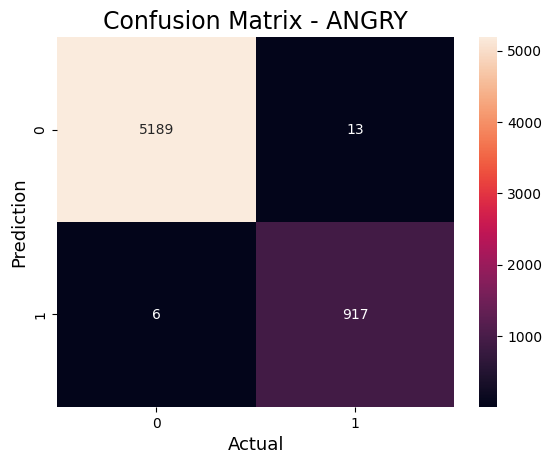

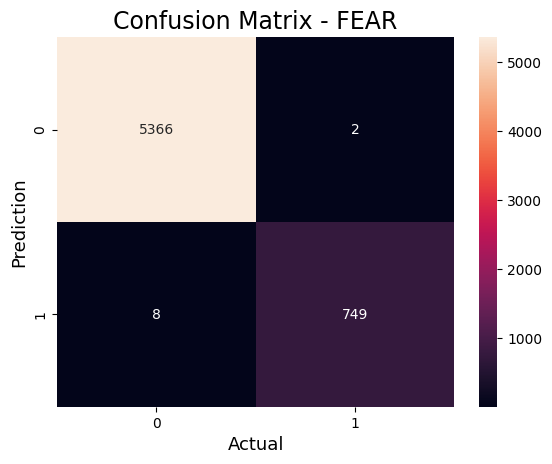

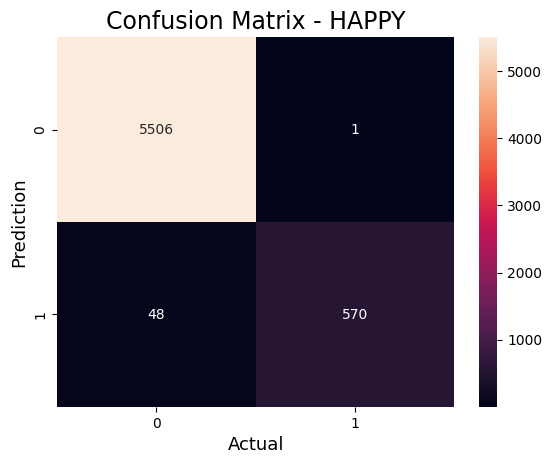

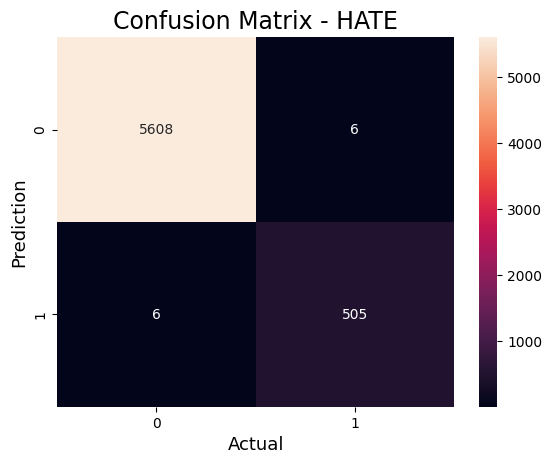

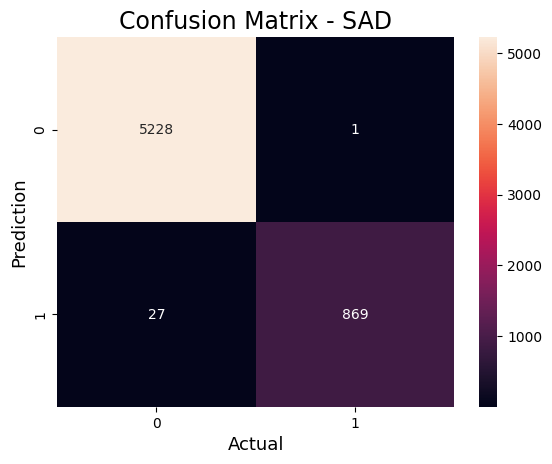

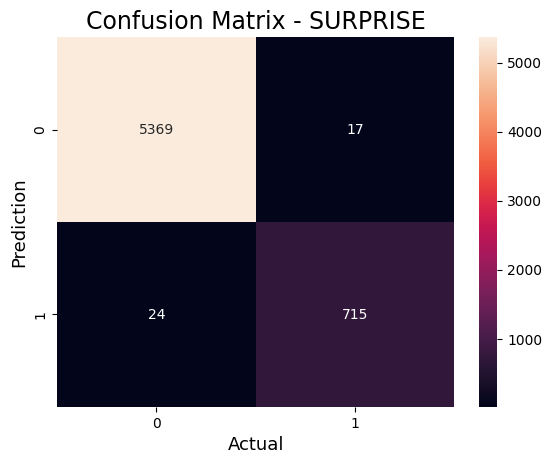

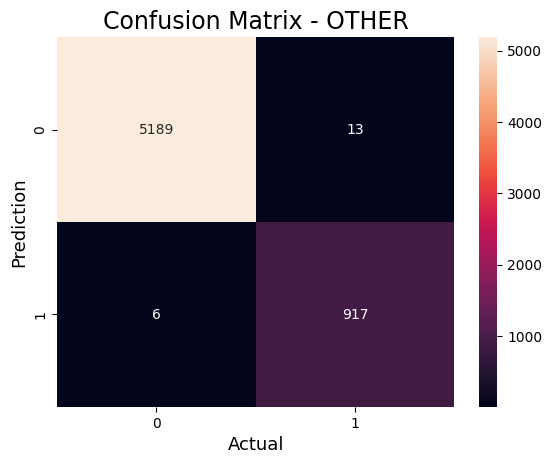

In [32]:
# Plot all Confusion Matrices
for lbl, cm in confusion_matrices.items():
    sns.heatmap(cm, annot=True, fmt='g')
    plt.ylabel('Prediction', fontsize=13)
    plt.xlabel('Actual', fontsize=13)
    plt.title(f'Confusion Matrix - {lbl}', fontsize=17)
    plt.savefig(f'confusion_matrix_{lbl}.png')  # Save the confusion matrix plot as an image
    plt.show()

#Test 5 sentences

In [33]:
df_rnd_test = df_test.sample(n=5).reset_index(drop=True)
df_rnd_test.head()

,text,labels
0,یه مستند دیدم بنام انقلاب جنسی در دو قسمت بود ...,"[1, 0, 0, 0, 0, 0, 0]"
1,خاور میانه را به آتش‌کشیدند و جابجا خارهای سیا...,"[0, 0, 0, 1, 0, 0, 0]"
2,الان عادل توی نود هفته بعد یه‌کلیپ حماسی از کی...,"[1, 0, 0, 0, 0, 0, 0]"
3,باباجون‌چه خبرتونه ؟ طی دو روز گذشته انتصاباتی...,"[0, 1, 0, 0, 0, 0, 0]"
4,فیلم ترسناک شد که,"[0, 0, 0, 0, 0, 1, 0]"


In [34]:
test_rnd_params = {'batch_size': 1,
                'shuffle': False,
                'num_workers': 0
                }

test_rnd_set = MultiLabelDataset(df_rnd_test, tokenizer, MAX_LEN)
testing_rnd_loader = DataLoader(test_rnd_set, **test_rnd_params)

outputs, targets = predict(testing_rnd_loader)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
5it [00:00, 34.46it/s]


In [35]:
def one_hot_to_string(one_hot):
    if  one_hot == [0, 0, 0, 0, 0, 0, 1]:
        return "ANGRY"
    elif one_hot == [0, 0, 0, 0, 0, 1, 0]:
        return "FEAR"
    elif one_hot == [0, 0, 0, 0, 1, 0, 0]:
        return "HAPPY"
    elif one_hot == [0, 0, 0, 1, 0, 0, 0]:
        return "HATE"
    elif one_hot == [0, 0, 1, 0, 0, 0, 0]:
        return "SAD"
    elif one_hot == [0, 1, 0, 0, 0, 0, 0]:
        return "SURPRISE"
    elif one_hot == [1, 0, 0, 0, 0, 0, 0]:
        return "OTHER"

In [36]:
final_outputs_rnd = class_finder(outputs)

for ind in df_rnd_test.index:
    print(f"The text is :{df_rnd_test['text'][ind]}")
    print(f"The True Label is : {one_hot_to_string(df_rnd_test['labels'][ind])}")
    print(f"The Predicted label is {one_hot_to_string(list(final_outputs_rnd[ind]))}")

The text is :یه مستند دیدم بنام انقلاب جنسی در دو قسمت بود . ‌فکر میکنم مستند خوبی بود . بدون هر گونه قضاوت دو قسمت این مستند را تا انتها ببینید . اینقدر بد صدا و سیما و مسئولان ما عمل کردند که خود من در ابتدا جبهه گرفته بودم و پس از پایان متوجه شدم اشتباه کردم . ‌دیدنش خالی از لطف نیست . 
The True Label is : OTHER
The Predicted label is OTHER
The text is :خاور میانه را به آتش‌کشیدند و جابجا خارهای سیاه خشم و نفرت رویاندند حالا نشستهاند به تماشای‌سیهروزی‌مردمانش « رویای آمریکایی » شاید همین باشد
The True Label is : HATE
The Predicted label is HATE
The text is :الان عادل توی نود هفته بعد یه‌کلیپ حماسی از کیروش پخش میکنه و این موفقیت‌رو ربط میده به کیروش
The True Label is : OTHER
The Predicted label is OTHER
The text is :باباجون‌چه خبرتونه ؟ طی دو روز گذشته انتصاباتی را در شهرداری دیدم که طرف حتی الفبای کار را نمیدونه‌ !!! بدون هیچ سابقه کاری و دارای قرارداد کارگری ( خنده حضار ) خیانت _ به _ شهر
The True Label is : SURPRISE
The Predicted label is SURPRISE
The text is :فیلم ترسناک شد که
T

In [37]:
def predict_text(text):
  tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')
  MAX_LEN=256
  df= pd.DataFrame([text], columns=['text'])
  inputs = tokenizer.encode_plus(
      text,
      None,
      add_special_tokens=True,
      max_length= MAX_LEN,
      pad_to_max_length=True,
      return_token_type_ids=True
  )

  ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device, dtype = torch.long)
  mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device, dtype = torch.long)
  token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).to(device, dtype = torch.long)

  with torch.no_grad():
    outputs = model(ids, mask, token_type_ids)
  probabilities = torch.sigmoid(outputs).squeeze().tolist()
  final_output = [0,0,0,0,0,0,0]
  index=np.argmax(probabilities)
  final_output[index] = 1
  print(f"the text is: {text}")
  print(f"the label is: {one_hot_to_string(list(final_output))}")


a = predict_text("امروز برای من خیلی روز خوبی بود")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


the text is: امروز برای من خیلی روز خوبی بود
the label is: HAPPY


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
